# MSA 2024 Phase 2 - Part 2{-}
In this part, I will train a model on the pre-processed data to predict sales numbers for a specific period based on input features. The goal is to predict the sales of the give features. 
These features include: 


## 1. Import libraries and pre-define functions{-}

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def smape(y_true, y_pred):
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Calculate the numerator (absolute difference)
    numerator = np.abs(y_true - y_pred)
    # Calculate the denominator (average of absolute actual and predicted values)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Calculate SMAPE
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value


## 2. Load and split preprocessed data{-}
Since I am going to build a time series regression model, I will use the data before 2017/1/1 as training set, and after 2017/1/1 as testing set.

In [5]:
# Load dataset
df = pd.read_csv('./dataset/store_sales_selected.csv', encoding='latin-1')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Year']-2014
df = df.set_index('Order Date')


In [6]:
df.tail(10)

,Ship Mode,Segment,City,Sub-Category,Sales,Quantity,Discount,Profit,Day of Week,Year,Month,Quarter,Days
Order Date,,,,,,,,,,,,,
2017-12-28,3,1,316,2,7.4000,2,0.00,3.0340,3,3,12,4,1451
2017-12-28,3,0,294,0,78.8528,2,0.32,-11.5960,3,3,12,4,1451
2017-12-28,3,1,261,2,7.9680,3,0.60,-2.3904,3,3,12,4,1451
2017-12-29,2,0,185,1,258.7500,3,0.00,77.6250,4,3,12,4,1452
2017-12-29,2,0,185,1,300.9800,1,0.00,87.2842,4,3,12,4,1452
2017-12-29,2,0,185,1,1207.8400,8,0.00,314.0384,4,3,12,4,1452
2017-12-29,3,0,184,1,393.5680,4,0.20,-44.2764,4,3,12,4,1452
2017-12-29,3,1,5,2,101.1200,8,0.00,37.4144,4,3,12,4,1452
2017-12-29,3,0,95,2,68.4600,2,0.00,20.5380,4,3,12,4,1452


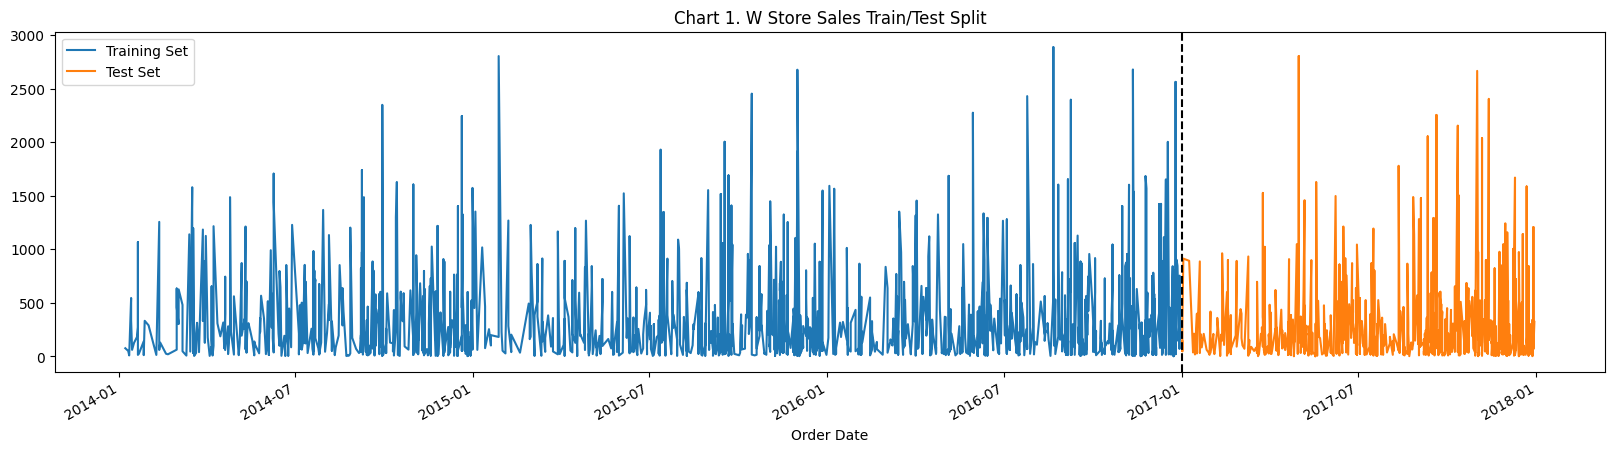

In [7]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, y='Sales', label='Training Set', title='Chart 1. W Store Sales Train/Test Split')
test.plot(ax=ax,y='Sales', label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## 3. Choose an algorithm{-}

I am going to build a boosted tree using xgboost and a multi-variable regression model, and compare the results by RMSE, SMAPE

In [10]:
FEATURES = [col for col in df.columns if col != 'Sales']
TARGET = 'Sales'
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
FEATURES

['Ship Mode',
 'Segment',
 'City',
 'Sub-Category',
 'Quantity',
 'Discount',
 'Profit',
 'Day of Week',
 'Year',
 'Month',
 'Quarter',
 'Days']

## 4. Train and test a model{-}
### 4.1 Boosted tree {-}

In [302]:
# Do a grid search to find the best hyperparameters
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [1, 3, 5],
    'n_estimators': [ 500, 1000],
    'reg_alpha': [ 0.5, 0.9, 2,5],
    'reg_lambda': [2, 5, 10,15]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=10; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=5; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=15; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0.5, reg_lambda=5; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=1, n_estimators=500, reg_alpha=0

In [303]:
boosted_tree_model = xgb.XGBRegressor(**best_params)

boosted_tree_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:411.75337	validation_1-rmse:379.13466


[100]	validation_0-rmse:273.63304	validation_1-rmse:265.93358
[200]	validation_0-rmse:219.67771	validation_1-rmse:224.74219
[300]	validation_0-rmse:194.34965	validation_1-rmse:207.35065
[400]	validation_0-rmse:181.51395	validation_1-rmse:201.56899
[500]	validation_0-rmse:173.52989	validation_1-rmse:198.27698
[600]	validation_0-rmse:168.04950	validation_1-rmse:196.46355
[700]	validation_0-rmse:164.09878	validation_1-rmse:194.89002
[800]	validation_0-rmse:160.42987	validation_1-rmse:193.29047
[900]	validation_0-rmse:157.58861	validation_1-rmse:193.61784
[999]	validation_0-rmse:155.14672	validation_1-rmse:195.76415


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

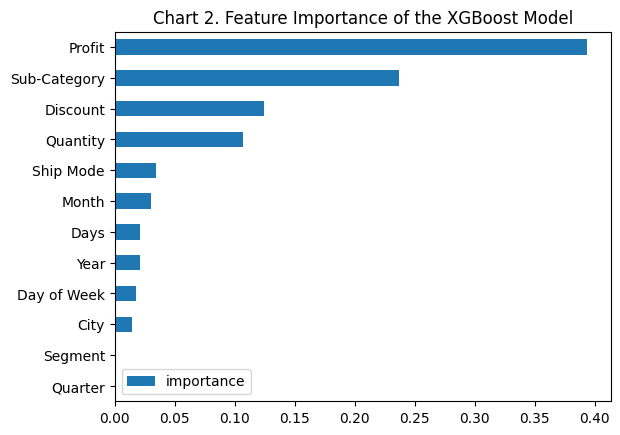

In [304]:
fi = pd.DataFrame(data=boosted_tree_model.feature_importances_,
             index=boosted_tree_model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Chart 2. Feature Importance of the XGBoost Model')
plt.show()

### 4.2 Multi-variable linear regression {-}

In [305]:
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

## 5. Evaluate the model {-}

In [306]:
# Make predictions with XGBoost
y_pred_xgb = boosted_tree_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f"XGBoost RMSE: {rmse_xgb}")

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
print(f"Linear Regression RMSE: {rmse_linear}")

XGBoost RMSE: 195.76415050568806
Linear Regression RMSE: 323.5036696346123


In [310]:
# Calculate R^2 for Linear Regression
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Linear Regression R^2: {r2_linear}")

# Calculate R^2 for XGBoost
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost R^2: {r2_xgb}")

Linear Regression R^2: 0.2701472935342507
XGBoost R^2: 0.7327343603595161


The result of boosted tree is better than the linear regression model. Let's explore some other metics and visualise the results

/var/folders/w8/w02d673x2yl186vbpbmfssbh0000gn/T/ipykernel_50612/3029988083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = boosted_tree_model.predict(X_test)


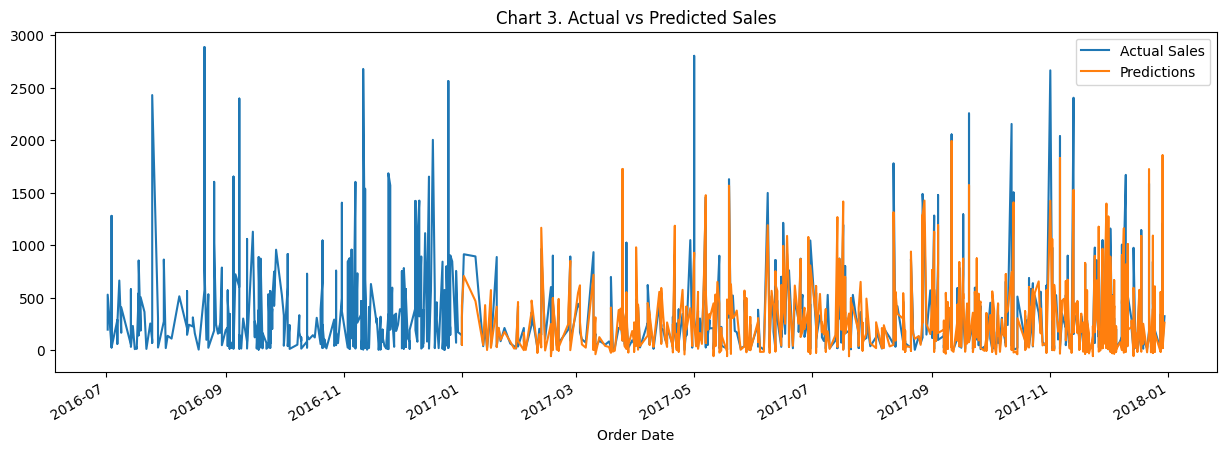

In [312]:
test['prediction'] = boosted_tree_model.predict(X_test)
df_merged = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_merged = df_merged.loc[(df_merged.index >= '07-01-2016')]
ax = df_merged[['Sales']].plot(figsize=(15, 5))
df_merged['prediction'].plot(ax=ax)
plt.legend(['Actual Sales', 'Predictions'])
ax.set_title('Chart 3. Actual vs Predicted Sales')
plt.show()

In [308]:
# calcuate the SMAPE
smape_value_xgb = smape(y_test, y_pred_xgb)
print(f"sMAPE of xgb model: {smape_value_xgb:.2f}%")
smape_value_lr = smape(y_test, y_pred_linear)
print(f"sMAPE of lr model: {smape_value_lr:.2f}%")


sMAPE of xgb model: 34.01%
sMAPE of lr model: 44.09%


## 6. Summary {-}
### Model Training and Evaluation {-}
- **Features used:**
   - 'Ship Mode',
   - 'Segment',
   - 'City',
   - 'Sub-Category',
   - 'Quantity',
   - 'Discount',
   - 'Profit', this is the most dominant feature. Although it may seem unusual, we assume it is available for predicting sales.
   - 'Day of Week',
   - 'Year',
   - 'Month',
   - 'Quarter',
   - 'Days'
   
- **Training/Test Splits:**
   - Used data before 2017 as the training set and data from 2017 onwards as the test set to ensure consistency and prevent data leaking. 

- **Algorithms Used:**
   - Boosted Tree using XGBoost.
   - Multi-variable Linear Regression.

- **Hyperparameter Tuning:**
   - Employed Cross-Validation Grid Search to optimize the parameters for both models.

- **Performance Metrics:**
   - Boosted Tree: 
     - RMSE: 195.7 
     - sMAPE: 34.01%
     - R^2: 73%
   - Linear Regression: 
     - RMSE: 323.5 
     - sMAPE: 44.09%
     - R^2: 27%

   The R-squared value for the boosted tree model indicates that it explains about 73% of the variance in the sales data, compared to only 27% for the linear regression model. The RMSE and sMAPE values for the boosted tree model are also lower, indicating better predictive accuracy and lower percentage error compared to the linear regression model.

### Conclusion {-}
The boosted tree model outperforms the linear regression model, indicating its ability to capture non-linear patterns in the data. Despite this, there is room for improvement in overall performance. Potential enhancements include explicitly modeling trends and seasonal patterns separately and refining the prediction task to be more specific, such as focusing on certain categories or cities.


